In [119]:
import pandas as pd
import matplotlib.pyplot as plt

spx = pd.read_csv(
    "data/SPX.csv",
    sep=";",
    usecols=["Date", "Close"],
    parse_dates=["Date"]
)
spx["Date"] = pd.to_datetime(spx["Date"], format="mixed", dayfirst=False, errors="coerce")




spx = spx[["Date", "Close"]].rename(columns={"Close": "Price"})
spx = spx.sort_values("Date")


# Nur die ersten beiden Spalten einlesen, Header manuell setzen
kgv = pd.read_csv(
    "KGV.csv",
    sep=";",             # fest auf Semikolon setzen
    skiprows=1,          # erste Zeile ("Tabelle 1") überspringen
    usecols=[0, 1],      # nur Datum und KGV
    names=["Date", "PE Ratio"],  # eigene Spaltennamen
    header=None
)

# Datentypen bereinigen
kgv["Date"] = pd.to_datetime(kgv["Date"], errors="coerce")
kgv["PE Ratio"] = pd.to_numeric(kgv["PE Ratio"], errors="coerce")

# Aufräumen
kgv = kgv.dropna().sort_values("Date")


# Sicherstellen, dass Datumsspalten korrekt sind
spx["Date"] = pd.to_datetime(spx["Date"], format="mixed", dayfirst=False, errors="coerce")
spx["Price"] = spx["Price"].astype(str).str.replace(",", "").astype(float)

kgv["Date"] = pd.to_datetime(kgv["Date"])

# 1. Vollständigen täglichen Zeitraum erzeugen (von min bis max in SPX)
full_dates = pd.DataFrame({"Date": pd.date_range(start=spx["Date"].min(), end=spx["Date"].max(), freq="D")})

# 2. KGV auf vollen Datumsbereich mergen
kgv_full = full_dates.merge(kgv, on="Date", how="left")

# 3. Interpolation und Extrapolation (linear in beide Richtungen)
kgv_full["PE Ratio"] = kgv_full["PE Ratio"].interpolate(method="linear", limit_direction="both")

# 4. Auf SPX-Daten reduzieren (nur Tage mit Kursdaten)
kgv_on_spx_days = spx.merge(kgv_full, on="Date", how="left")

# 5. Ergebnis anzeigen
print(kgv_on_spx_days.tail())

            Date    Price  PE Ratio
24426 2025-03-31  5488.73  27.81871
24427 2025-04-01  5558.52  27.80000
24428 2025-04-02  5571.48  26.93000
24429 2025-04-03  5390.83  26.06000
24430 2025-04-04  5069.90  25.19000


/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_18597/1828262839.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  kgv["Date"] = pd.to_datetime(kgv["Date"], errors="coerce")


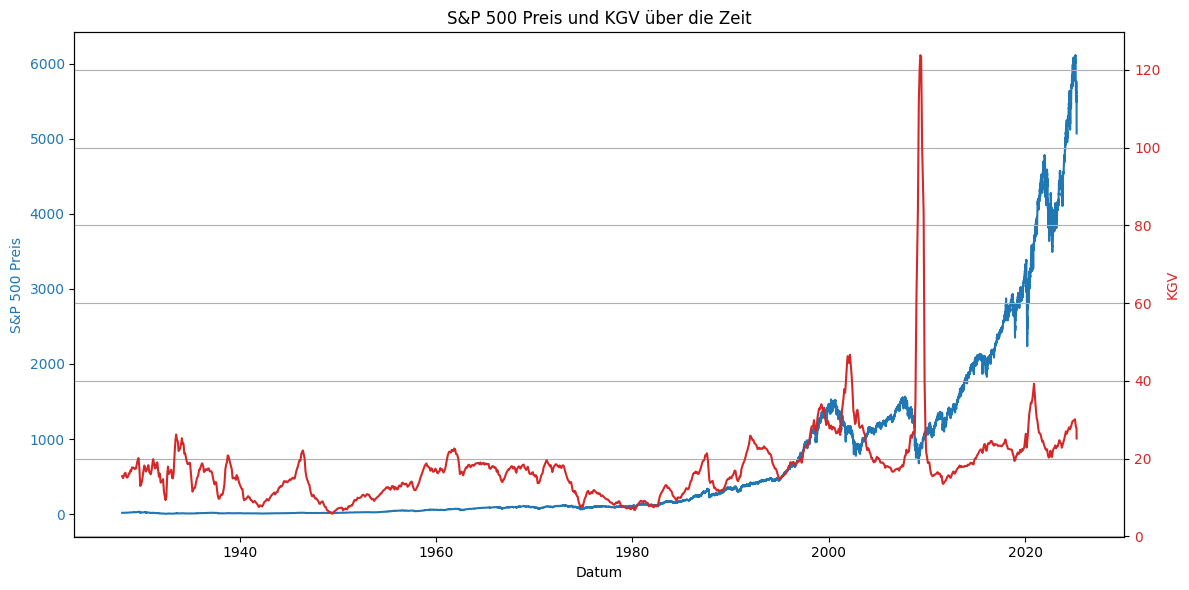

In [100]:
# --- 6. Plot: Preis und KGV über die Zeit ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Linke Achse: Preis
ax1.set_xlabel("Datum")
ax1.set_ylabel("S&P 500 Preis", color="tab:blue")
ax1.plot(kgv_on_spx_days["Date"], kgv_on_spx_days["Price"], color="tab:blue", label="S&P 500 Preis")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Rechte Achse: KGV
ax2 = ax1.twinx()
ax2.set_ylabel("KGV", color="tab:red")
ax2.plot(kgv_on_spx_days["Date"], kgv_on_spx_days["PE Ratio"], color="tab:red", label="KGV")
ax2.tick_params(axis='y', labelcolor="tab:red")

# Titel und Layout
plt.title("S&P 500 Preis und KGV über die Zeit")
fig.tight_layout()
plt.grid(True)
plt.show()


In [118]:
import numpy as np
from scipy.stats import norm

def reverse_bonus_zertifikat_analytisch(
    S0,         # aktueller Indexstand (z. B. 5070)
    H,          # Barriere (z. B. 6000)
    R,          # Reversebetrag (z. B. 65 EUR)
    bonus,      # Bonusauszahlung bei intakter Barriere (z. B. 17 EUR)
    BR,         # Bezugsverhältnis (z. B. 0.01)
    r,          # risikofreier Zinssatz (z. B. 0.03 für 3%)
    sigma,      # Volatilität (z. B. 0.20)
    T           # Restlaufzeit in Jahren (z. B. 358/365)
):
    # Strike des Put ergibt sich aus: Auszahlung bei Knock-In = max(0, R - S_T * BR)
    K = R / BR

    # d1 und d2 für Black-Scholes Put
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Preis des europäischen Puts
    put_price = BR * (K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1))

    # Wahrscheinlichkeit, dass Barriere NICHT berührt wird (Brownian Bridge)
    mu = (np.log(S0 / H)) / (sigma * np.sqrt(T))
    P_no_touch = 1 - np.exp(-2 * mu**2)

    # Fairer Preis des Reverse Bonus Zertifikats
    V = np.exp(-r * T) * (P_no_touch * bonus) + (1 - P_no_touch) * put_price

    return V

# Beispielwerte (wie zuvor)
S0 = 5662
H = 6000
R = 65
bonus = 17
BR = 0.01
r = 0.03
sigma = 0.2
T = 365 / 365

reverse_bonus_zertifikat_analytisch(S0, H, R, bonus, BR, r, sigma, T)


26.204522892569234